# Import data file

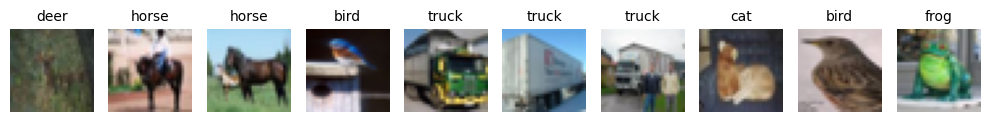

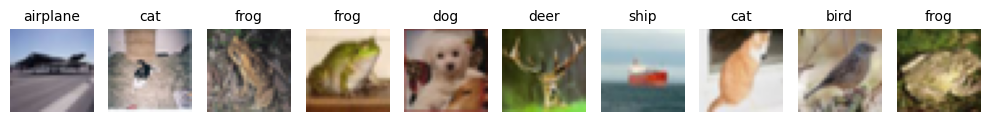

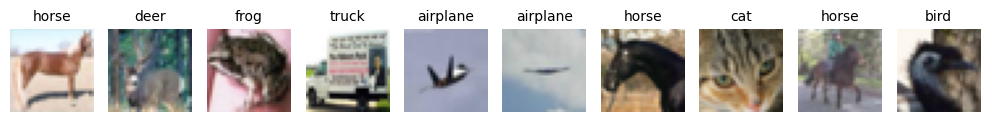

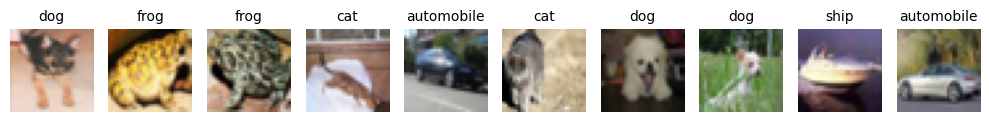

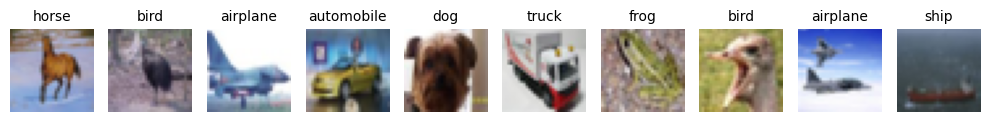

(50000, 32, 32, 3)
50000


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'


# Load the batch 
validation_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch')
# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']


def load_cifar10_batches(cifar10_dir, batch_ids):
    images = []
    labels = []
    
    for batch_id in batch_ids:
        batch_path = os.path.join(cifar10_dir, f'data_batch_{batch_id}')
        with open(batch_path, 'rb') as file:
            batch = pickle.load(file, encoding='bytes')
            img = batch[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
            lb = batch[b'labels']
            plt.figure(figsize=(10, 10))  # Adjusted figure size for better visibility
            for i in range(10):  # Loop through the first 100 images
                plt.subplot(1, 10, i + 1)  # Arrange plots in 10x10 grid
                plt.imshow(img[i+10])
                plt.title(label_names[lb[i+10]].decode('utf-8'), fontsize=10)  # Ensure title is small enough to fit
                plt.axis('off')
            plt.tight_layout()  # Adjust subplots to fit in the figure area
            plt.show()
            
            images.append(batch[b'data'])
            labels.append(batch[b'labels'])
    
    images = np.concatenate(images).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    #print(type(images))
    #print(images.shape)
    #images = images.astype('float32')
    labels = np.concatenate(labels)
    
    return images, labels



train_images, train_labels = load_cifar10_batches(cifar10_dir, range(1, 6))
validation_images = validation_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)#.astype('float32')
validation_labels = validation_batch[b'labels']
print(train_images.shape)
print(len(train_labels))
#print(validation_images[0])
#print(train_images[0])
import numpy as np

# Concatenate the training and validation images
train_images = np.concatenate((train_images, validation_images), axis=0)

# Concatenate the training and validation labels
train_labels = np.concatenate((train_labels, validation_labels), axis=0)

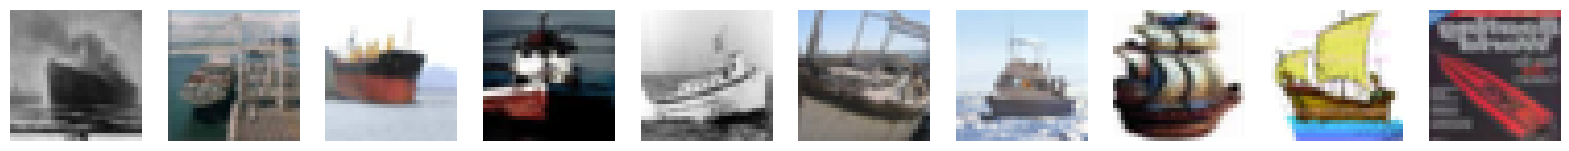

In [2]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

# Load the batch 
test_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')

# Extract images
images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) 



plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# create Image Data set

In [3]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, images, labels = None, transform=None,test=False,gan = False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
        self.test = test
        self.gan = gan
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx];

        if self.transform:
            image = self.transform(image=image)['image']
            
        if self.gan:
            return image, 1
            
        if self.test:
            return image
        
        label = self.labels[idx]
        
        return image, label

# Data augmentation

In [4]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

transforms_train = albumentations.Compose(
    [

        albumentations.Resize(64, 64),
        albumentations.HorizontalFlip(p=0.5),
        #albumentations.VerticalFlip(p=0.5),
        albumentations.Rotate(limit=45, p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=(-0.5, 0.5), p=0.5),
        albumentations.ShiftScaleRotate(
            shift_limit=0.2, scale_limit=(-0.2,0.5), rotate_limit=0
        ),
        albumentations.Normalize(
            [0.4914, 0.4822, 0.4465],[0.247, 0.243, 0.261],
            max_pixel_value=255.0, always_apply=True
        ),
        ToTensorV2(p=1.0),
    ]
)

transforms_test = albumentations.Compose(
        [
            albumentations.Resize(64, 64),
            #albumentations.Resize(144, 144),
            albumentations.Normalize(
                [0.4914, 0.4822, 0.4465],[0.247, 0.243, 0.261],
                max_pixel_value=255.0, always_apply=True
            ),
            ToTensorV2(p=1.0)
        ]
    )

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets 
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,ExponentialLR
# net = torchvision.models.resnet18()
# in_features = net.fc.in_features
# net.fc = nn.Linear(in_features, 10)

# Data Augmentation Image domain transfer using cycle gan

In [6]:
import torch
from torch import nn
from torchvision import transforms, datasets
import torch.optim as optim

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(3, 64, 4, stride=2, padding=1), # Assuming 3-channel images
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, 4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)
import torch
from torch import nn

class ResBlock(nn.Module):
    def __init__(self, in_features):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, num_residual_blocks=2):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 16, 7),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # Downsample
        self.downsample = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 96, 3, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True)
        )

        # Residual blocks
        self.resblocks = nn.Sequential(
            *[ResBlock(96) for _ in range(num_residual_blocks)]
        )

        # Upsample
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(96, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(16, input_channels, 7),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample(x)
        x = self.resblocks(x)
        x = self.upsample(x)
        x = self.output(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 4, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(4, 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

    # Initialize networks
G_A2B = Generator()
G_B2A = Generator()
D_A = Discriminator()
D_B = Discriminator()

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_A2B = G_A2B.to(device)
G_B2A = G_B2A.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)

In [8]:
loader_A = ImageDataset(validation_images, train_labels,transform = transforms_test)

loader_B = ImageDataset(images, gan = True, transform = transforms_test )

loader_A = DataLoader(loader_A, batch_size=128, shuffle=True, drop_last=False)
loader_B = DataLoader(loader_B, batch_size=128, shuffle=True, drop_last=False)

In [9]:
import torch

def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

In [10]:
import torch

# Assuming 'loader_A' and 'loader_B' are your DataLoader instances for domain A and B.
# Number of epochs
n_epochs = 20

# Lambda terms for cycle and identity loss
lambda_cycle = 5.0
lambda_identity = 1.0
from tqdm.auto import tqdm
for epoch in range(n_epochs):
    for batch_A, batch_B in tqdm(zip(loader_A, loader_B)):
        real_A = batch_A[0].to(device)
        real_B = batch_B[0].to(device)

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        same_B = G_A2B(real_B)
        loss_identity_B = criterion_cycle(same_B, real_B) * lambda_identity
        same_A = G_B2A(real_A)
        loss_identity_A = criterion_cycle(same_A, real_A) * lambda_identity

        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake = D_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_A = G_B2A(real_B)
        pred_fake = D_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        # Cycle loss
        recovered_A = G_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_cycle

        recovered_B = G_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_cycle

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        optimizer_G.step()

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = D_A(real_A)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = D_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = D_B(real_B)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = D_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch {epoch}/{n_epochs} finished")
    print(f"Loss G: {loss_G.item():.4f}, "
          f"Loss D_X: {loss_D_A.item():.4f}, Loss D_Y: {loss_D_B.item():.4f}")
#     if (epoch+1) % 1 == 0:  # Save every 10 epochs
#         print(f"Epoch {epoch} saved")
#         save_checkpoint(G_A2B, optimizer_G, epoch, f'checkpoint_{epoch+1}.pth')


0it [00:00, ?it/s]

Epoch 0/20 finished
Loss G: 4.3909, Loss D_X: 0.2493, Loss D_Y: 0.2507


0it [00:00, ?it/s]

Epoch 1/20 finished
Loss G: 3.8637, Loss D_X: 0.2488, Loss D_Y: 0.2497


0it [00:00, ?it/s]

Epoch 2/20 finished
Loss G: 4.3259, Loss D_X: 0.2454, Loss D_Y: 0.2498


0it [00:00, ?it/s]

Epoch 3/20 finished
Loss G: 3.8873, Loss D_X: 0.2472, Loss D_Y: 0.2483


0it [00:00, ?it/s]

Epoch 4/20 finished
Loss G: 3.9034, Loss D_X: 0.2347, Loss D_Y: 0.2288


0it [00:00, ?it/s]

Epoch 5/20 finished
Loss G: 3.7365, Loss D_X: 0.2368, Loss D_Y: 0.2348


0it [00:00, ?it/s]

Epoch 6/20 finished
Loss G: 4.4539, Loss D_X: 0.2155, Loss D_Y: 0.2144


0it [00:00, ?it/s]

Epoch 7/20 finished
Loss G: 4.2495, Loss D_X: 0.2163, Loss D_Y: 0.2118


0it [00:00, ?it/s]

Epoch 8/20 finished
Loss G: 4.3223, Loss D_X: 0.2055, Loss D_Y: 0.1992


0it [00:00, ?it/s]

Epoch 9/20 finished
Loss G: 4.1754, Loss D_X: 0.2602, Loss D_Y: 0.1817


0it [00:00, ?it/s]

Epoch 10/20 finished
Loss G: 4.4036, Loss D_X: 0.1956, Loss D_Y: 0.1810


0it [00:00, ?it/s]

Epoch 11/20 finished
Loss G: 4.0204, Loss D_X: 0.1710, Loss D_Y: 0.1646


0it [00:00, ?it/s]

Epoch 12/20 finished
Loss G: 4.0086, Loss D_X: 0.1905, Loss D_Y: 0.1610


0it [00:00, ?it/s]

Epoch 13/20 finished
Loss G: 5.3412, Loss D_X: 0.0857, Loss D_Y: 0.2072


0it [00:00, ?it/s]

Epoch 14/20 finished
Loss G: 4.6547, Loss D_X: 0.1108, Loss D_Y: 0.1368


0it [00:00, ?it/s]

Epoch 15/20 finished
Loss G: 4.6569, Loss D_X: 0.0738, Loss D_Y: 0.1612


0it [00:00, ?it/s]

Epoch 16/20 finished
Loss G: 4.3358, Loss D_X: 0.0416, Loss D_Y: 0.1830


0it [00:00, ?it/s]

Epoch 17/20 finished
Loss G: 5.0038, Loss D_X: 0.0306, Loss D_Y: 0.0999


0it [00:00, ?it/s]

Epoch 18/20 finished
Loss G: 5.0972, Loss D_X: 0.0285, Loss D_Y: 0.0952


0it [00:00, ?it/s]

Epoch 19/20 finished
Loss G: 4.5649, Loss D_X: 0.0267, Loss D_Y: 0.0757


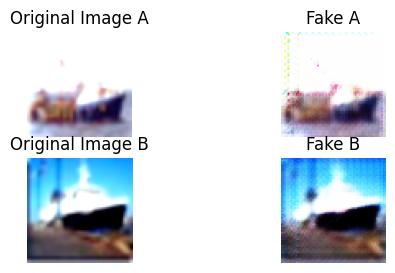

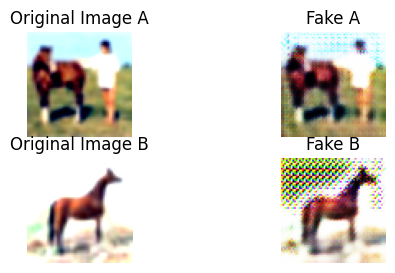

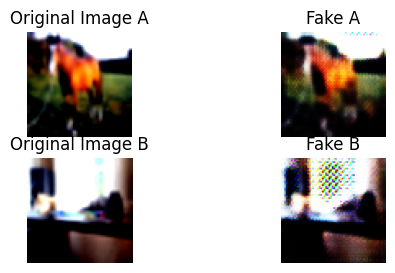

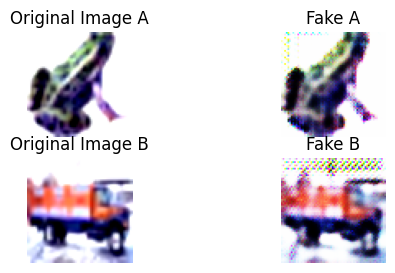

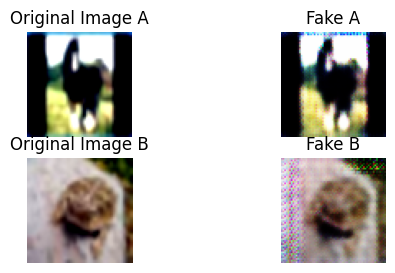

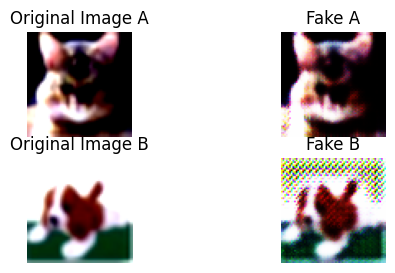

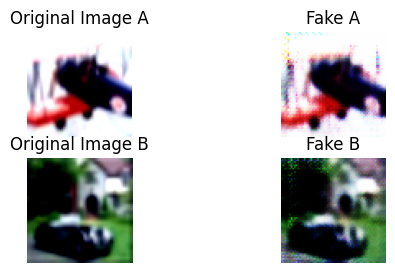

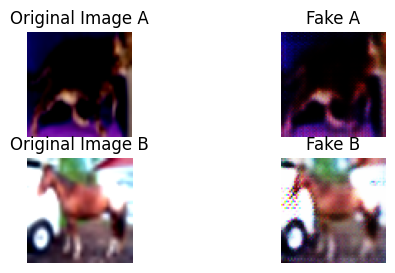

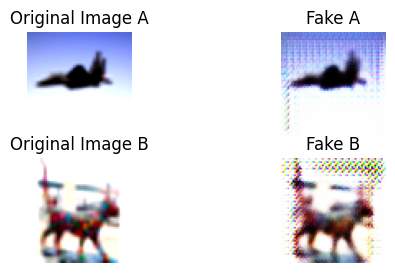

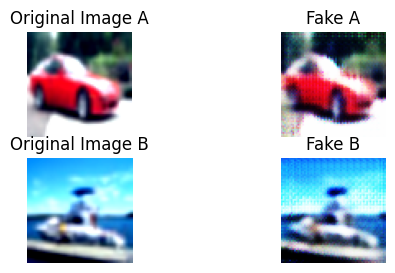

In [11]:
import matplotlib.pyplot as plt
import torch

def visualize_cycleGAN_results(model_G_A2B, model_G_B2A, test_loader_A, test_loader_B):
    # Switch models to evaluation mode
    model_G_A2B.eval()
    model_G_B2A.eval()
    count = 0
    with torch.no_grad(): # No need to track gradients
        for batchA,batchB in zip(test_loader_A,test_loader_B):
            real_A, _ = batchA
            real_B, _ = batchB
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            count+=1;
            
            # Generate images from domain A to B and back to A
            fake_A = model_G_A2B(real_A)
            fake_B = model_G_B2A(real_B)
            
            # Move images back to CPU for visualization
            real_A = real_A.cpu()
            real_B = real_B.cpu()
            fake_A = fake_A.cpu()
            fake_B = fake_B.cpu()

            # Plot the original, transformed, and reconstructed images
            plt.figure(figsize=(6, 3))
            
            # Display real image
            plt.subplot(2, 2, 1)
            plt.title("Original Image A")
            plt.imshow(real_A[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')
            
             # Display real image
            plt.subplot(2, 2, 2)
            plt.title("Fake A")
            plt.imshow(fake_A[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')
            
            # Display real image
            plt.subplot(2, 2, 3)
            plt.title("Original Image B")
            plt.imshow(real_B[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')
            
             # Display real image
            plt.subplot(2, 2, 4)
            plt.title("Fake B")
            plt.imshow(fake_B[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) # Unnormalize
            plt.axis('off')

            plt.show()
            if count == 10:
                break # Just show one set of images for example

# Assuming model_G_A2B, model_G_B2A, and test_loader_A are defined and loaded
visualize_cycleGAN_results(G_A2B, G_B2A, loader_A,loader_B)


In [12]:
G_A2B.eval()
G_B2A.eval()

Generator(
  (initial): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (downsample): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (resblocks): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad

# The model

In [13]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(DLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        

        self.layer3 = Tree(block,  32,  64, level=1, stride=2)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=1, stride=2)
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=2, stride=2, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(True)
#         )
        #self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        #out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# def test():
#     net = DLA()
#     print(net)
#     x = torch.randn(1, 3, 32, 32)
#     y = net(x)
#     print(y.size())


net = DLA()

# Teacher model

In [14]:
import timm
parent = timm.create_model('dla102', pretrained=False,num_classes=10)

In [15]:
!pip install torch-summary

In [16]:
from torchsummary import summary
summary(net, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 16, 64, 64]          432
|    └─BatchNorm2d: 2-2                  [-1, 16, 64, 64]          32
|    └─ReLU: 2-3                         [-1, 16, 64, 64]          --
├─Sequential: 1-2                        [-1, 16, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 16, 64, 64]          2,304
|    └─BatchNorm2d: 2-5                  [-1, 16, 64, 64]          32
|    └─ReLU: 2-6                         [-1, 16, 64, 64]          --
├─Sequential: 1-3                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-7                       [-1, 32, 64, 64]          4,608
|    └─BatchNorm2d: 2-8                  [-1, 32, 64, 64]          64
|    └─ReLU: 2-9                         [-1, 32, 64, 64]          --
├─Tree: 1-4                              [-1, 64, 32, 32]          --
|    └─B

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 16, 64, 64]          432
|    └─BatchNorm2d: 2-2                  [-1, 16, 64, 64]          32
|    └─ReLU: 2-3                         [-1, 16, 64, 64]          --
├─Sequential: 1-2                        [-1, 16, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 16, 64, 64]          2,304
|    └─BatchNorm2d: 2-5                  [-1, 16, 64, 64]          32
|    └─ReLU: 2-6                         [-1, 16, 64, 64]          --
├─Sequential: 1-3                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-7                       [-1, 32, 64, 64]          4,608
|    └─BatchNorm2d: 2-8                  [-1, 32, 64, 64]          64
|    └─ReLU: 2-9                         [-1, 32, 64, 64]          --
├─Tree: 1-4                              [-1, 64, 32, 32]          --
|    └─B

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net  = net.to(device)
parent = parent.to(device)

# Train logic 

In [18]:
import torch

def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

In [19]:
from tqdm.auto import tqdm

def train_model(train_loader):
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.0002,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min = 1e-6)
    scheduler = ExponentialLR(optimizer, gamma=0.975,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        net.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            #print(x.shape)
            num = torch.rand(1).item()
            if num>=0 and num<0.25:
                x = G_A2B(x)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            #print(y.shape)
            #print(y)
            y_hat = net(x)
            #print(y_hat.shape)
            #print(y_hat)
            #print(y_hat.argmax(dim=1).type(y.dtype))
            loss_temp = loss(y_hat, y)
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")



In [20]:
from tqdm.auto import tqdm

def train_parent(train_loader):
    losses = []
    optimizer = optim.Adam(parent.parameters(), lr=0.0007,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min = 1e-6)
    scheduler = ExponentialLR(optimizer, gamma=0.975,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        parent.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            #print(x.shape)
            num = torch.rand(1).item()
            if num>=0 and num<0.2:
                x = G_A2B(x)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            #print(y.shape)
            #print(y)
            y_hat = parent(x)
            #print(y_hat.shape)
            #print(y_hat)
            #print(y_hat.argmax(dim=1).type(y.dtype))
            loss_temp = loss(y_hat, y)
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")


In [21]:
# class DistillationLoss(nn.Module):
#     def __init__(self, temperature=1):
#         super(DistillationLoss, self).__init__()
#         self.temperature = temperature

#     def forward(self, outputs_student, outputs_teacher):
#         soft_targets = nn.functional.softmax(outputs_teacher / self.temperature, dim=1)
#         log_probs = nn.functional.log_softmax(outputs_student / self.temperature, dim=1)
#         return nn.KLDivLoss(reduction='batchmean')(log_probs, soft_targets)


import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, temperature=1.0, alpha=0.5):
        """
        :param temperature: Temperature parameter to soften probability distributions.
        :param alpha: Weighting factor for the distillation loss vs. the standard loss.
        """
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, outputs_student, outputs_teacher, labels=None):
        """
        Compute the distillation loss between the student and teacher outputs.
        If labels are provided, also compute the standard loss and return a weighted sum.
        """
        soft_targets = F.softmax(outputs_teacher / self.temperature, dim=1)
        log_probs = F.log_softmax(outputs_student / self.temperature, dim=1)
        distillation_loss = self.kl_div(log_probs, soft_targets)
        
        if labels is not None:
            standard_loss = F.cross_entropy(outputs_student, labels)
            return self.alpha * standard_loss + (1 - self.alpha) * distillation_loss
        else:
            return distillation_loss


In [22]:
from tqdm.auto import tqdm

def train_model_with_teacher(train_loader):
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.0003,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
    distillation_loss = DistillationLoss(temperature=3) 
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min = 1e-6)
    scheduler = ExponentialLR(optimizer, gamma=0.975,verbose=True)
    for i in range(epoch):
        acc = 0
        loss_sum = 0
        net.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            #print(x.shape)
            num = torch.rand(1).item()
            if num>=0 and num<0.1:
                x = G_A2B(x)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)  
            y_hat = net(x)
            
            outputs_teacher = parent(x)
            outputs_student = net(x)
            
            loss_temp = loss(outputs_student, y) + distillation_loss(outputs_student, outputs_teacher)
            
            loss_sum += loss_temp
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
#             scheduler.step()
            acc += torch.sum(y_hat.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")
        if (i+1) % 10 == 0:  # Save every 10 epochs
            save_checkpoint(net, optimizer, epoch, f'checkpoint_final_{i+1}.pth')
            print( "saved epoch: ", i)


In [23]:
from tqdm.auto import tqdm

def teach_student(train_loader):
    losses = []
    optimizer = optim.Adam(net.parameters(), lr=0.0003,weight_decay=1e-5)
    teacher_optimizer = optim.Adam(parent.parameters(), lr=0.00003,weight_decay=1e-5)
    student_optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=1e-5)
    loss = nn.CrossEntropyLoss(reduction='mean')
    distillation_loss = DistillationLoss(temperature=3) 
    scheduler = ExponentialLR(teacher_optimizer, gamma=0.99,verbose=True)
    scheduler = ExponentialLR(student_optimizer, gamma=0.98,verbose=True)
    for i in range(epoch):
        acc = 0
        acc_t = 0
        loss_sum = 0
        net.train()
        parent.train()
        for x, y in tqdm(train_loader):
            teacher_optimizer.zero_grad()
            student_optimizer.zero_grad()
            x = x.to(device)
            #print(x.shape)
            x = torch.as_tensor(x, dtype=torch.float)
            y = y.to(device)
            
            outputs_teacher = parent(x)
            outputs_student = net(x)
            
            loss_teacher = loss(outputs_teacher, y)
            loss_student = loss(outputs_student, y) + distillation_loss(outputs_student, outputs_teacher)
#             print("loss")
#             print(loss(outputs_student, y))
#             print(distillation_loss(outputs_student, outputs_teacher))
#             print(outputs_teacher)
#             print(outputs_student)
            
            loss_sum += loss_teacher

            loss_teacher.backward(retain_graph=True)
#             loss_teacher.backward()
            loss_student.backward()
            teacher_optimizer.step()
            student_optimizer.step()
            
            acc += torch.sum(outputs_student.argmax(dim=1).type(y.dtype) == y)
            acc_t += torch.sum(outputs_teacher.argmax(dim=1).type(y.dtype) == y)
        scheduler.step()
        losses.append(loss_sum.cpu().detach().numpy() / len(train_loader))
        print( "epoch: ", i, "loss=", loss_sum.item(), "训练集准确度=",(acc/(len(train_loader)*train_loader.batch_size)).item(),end="")
        print( "epoch: ", i, "loss=", loss_sum.item(), "teacher准确度=",(acc_t/(len(train_loader)*train_loader.batch_size)).item(),end="")


In [24]:
#from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,ExponentialLR

print(train_images.shape)
print(train_labels.shape)
print(validation_images.shape)
validation_labels = np.array(validation_labels)
print(validation_labels.shape)

#train_dataset = ImageDataset(train_images, train_labels, transform=transforms_train)
train_dataset = ImageDataset(train_images, train_labels, transform=transforms_train)
validation_dataset = ImageDataset(validation_images, validation_labels, transform=transforms_test)
#submit_ds = ImageDataset(csv_file='/kaggle/input/classify-leaves/test.csv', root_dir='../input/classify-leaves', transform=transforms_test, label_return=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, drop_last=False)
#submit_loader = DataLoader(submit_ds, batch_size=32, shuffle=False, drop_last=False)

(60000, 32, 32, 3)
(60000,)
(10000, 32, 32, 3)
(10000,)


In [25]:
epoch = 60
train_parent(train_loader)

Adjusting learning rate of group 0 to 7.0000e-04.


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8250e-04.
epoch:  0 loss= 2553.8974609375 训练集准确度= 0.2581123411655426

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6544e-04.
epoch:  1 loss= 1812.1593017578125 训练集准确度= 0.3429337739944458

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4880e-04.
epoch:  2 loss= 1696.4473876953125 训练集准确度= 0.3811633884906769

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3258e-04.
epoch:  3 loss= 1720.30810546875 训练集准确度= 0.3862939774990082

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1677e-04.
epoch:  4 loss= 1622.927978515625 训练集准确度= 0.41306304931640625

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0135e-04.
epoch:  5 loss= 1521.49951171875 训练集准确度= 0.4580390453338623

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8631e-04.
epoch:  6 loss= 1518.3583984375 训练集准确度= 0.4535914361476898

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7166e-04.
epoch:  7 loss= 1421.1285400390625 训练集准确度= 0.4945529103279114

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5736e-04.
epoch:  8 loss= 1363.634033203125 训练集准确度= 0.5222048163414001

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4343e-04.
epoch:  9 loss= 1278.064697265625 训练集准确度= 0.5452259182929993

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2984e-04.
epoch:  10 loss= 1334.0399169921875 训练集准确度= 0.526735782623291

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1660e-04.
epoch:  11 loss= 1207.5501708984375 训练集准确度= 0.5749600529670715

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0368e-04.
epoch:  12 loss= 1188.8262939453125 训练集准确度= 0.5818396806716919

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9109e-04.
epoch:  13 loss= 1156.5762939453125 训练集准确度= 0.5926839113235474

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7881e-04.
epoch:  14 loss= 1128.1890869140625 训练集准确度= 0.6059601902961731

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6684e-04.
epoch:  15 loss= 1032.0592041015625 训练集准确度= 0.6327458620071411

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5517e-04.
epoch:  16 loss= 1029.8289794921875 训练集准确度= 0.63632732629776

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4379e-04.
epoch:  17 loss= 1095.5880126953125 训练集准确度= 0.6134728193283081

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3270e-04.
epoch:  18 loss= 909.0623168945312 训练集准确度= 0.669393002986908

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2188e-04.
epoch:  19 loss= 902.7153930664062 训练集准确度= 0.6755730509757996

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1133e-04.
epoch:  20 loss= 836.8267822265625 训练集准确度= 0.6913146376609802

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0105e-04.
epoch:  21 loss= 807.3934326171875 训练集准确度= 0.703125

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9102e-04.
epoch:  22 loss= 795.0211791992188 训练集准确度= 0.7091884613037109

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8125e-04.
epoch:  23 loss= 769.4483032226562 训练集准确度= 0.7167177796363831

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7172e-04.
epoch:  24 loss= 749.6765747070312 训练集准确度= 0.7255796790122986

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6242e-04.
epoch:  25 loss= 728.532470703125 训练集准确度= 0.7333589196205139

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5336e-04.
epoch:  26 loss= 714.6026000976562 训练集准确度= 0.7379730939865112

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4453e-04.
epoch:  27 loss= 709.8146362304688 训练集准确度= 0.7403551340103149

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3592e-04.
epoch:  28 loss= 667.3446655273438 训练集准确度= 0.7568963170051575

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2752e-04.
epoch:  29 loss= 704.6090698242188 训练集准确度= 0.745835542678833

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1933e-04.
epoch:  30 loss= 640.1925659179688 训练集准确度= 0.7649919986724854

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1135e-04.
epoch:  31 loss= 638.989501953125 训练集准确度= 0.7653751373291016

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0356e-04.
epoch:  32 loss= 604.2560424804688 训练集准确度= 0.777385413646698

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9597e-04.
epoch:  33 loss= 608.7313842773438 训练集准确度= 0.7770689129829407

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8858e-04.
epoch:  34 loss= 626.246337890625 训练集准确度= 0.7725213170051575

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8136e-04.
epoch:  35 loss= 585.5765380859375 训练集准确度= 0.7829990983009338

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7433e-04.
epoch:  36 loss= 573.3790893554688 训练集准确度= 0.7893790006637573

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6747e-04.
epoch:  37 loss= 585.0101928710938 训练集准确度= 0.7869636416435242

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6078e-04.
epoch:  38 loss= 581.3759155273438 训练集准确度= 0.7859641909599304

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5426e-04.
epoch:  39 loss= 567.29736328125 训练集准确度= 0.791111409664154

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4791e-04.
epoch:  40 loss= 545.2692260742188 训练集准确度= 0.7979410886764526

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4171e-04.
epoch:  41 loss= 521.5242309570312 训练集准确度= 0.8081023693084717

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3567e-04.
epoch:  42 loss= 530.7565307617188 训练集准确度= 0.8040544986724854

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2977e-04.
epoch:  43 loss= 523.2072143554688 训练集准确度= 0.8063532710075378

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2403e-04.
epoch:  44 loss= 533.4390258789062 训练集准确度= 0.8051705956459045

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1843e-04.
epoch:  45 loss= 519.5670166015625 训练集准确度= 0.8087520003318787

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1297e-04.
epoch:  46 loss= 486.48114013671875 训练集准确度= 0.821045458316803

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0764e-04.
epoch:  47 loss= 474.12310791015625 训练集准确度= 0.8243436813354492

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0245e-04.
epoch:  48 loss= 494.03216552734375 训练集准确度= 0.8177805542945862

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9739e-04.
epoch:  49 loss= 484.24517822265625 训练集准确度= 0.8213120102882385

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9246e-04.
epoch:  50 loss= 472.6865234375 训练集准确度= 0.8261260986328125

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8765e-04.
epoch:  51 loss= 462.73681640625 训练集准确度= 0.8302738666534424

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8295e-04.
epoch:  52 loss= 453.1879577636719 训练集准确度= 0.8325393199920654

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7838e-04.
epoch:  53 loss= 450.1444091796875 训练集准确度= 0.8342550992965698

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7392e-04.
epoch:  54 loss= 450.4340515136719 训练集准确度= 0.8341551423072815

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6957e-04.
epoch:  55 loss= 441.1745910644531 训练集准确度= 0.8363872766494751

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6533e-04.
epoch:  56 loss= 428.35052490234375 训练集准确度= 0.841484546661377

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6120e-04.
epoch:  57 loss= 436.0957336425781 训练集准确度= 0.8394856452941895

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5717e-04.
epoch:  58 loss= 418.3191223144531 训练集准确度= 0.8452825546264648

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5324e-04.
epoch:  59 loss= 413.5856628417969 训练集准确度= 0.8474313616752625

In [26]:
epoch = 60
teach_student(train_loader)
#net = parent
#train_model(train_loader,validation_loader)

Adjusting learning rate of group 0 to 3.0000e-05.
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8000e-04.
epoch:  0 loss= 433.8013000488281 训练集准确度= 0.3768823444843292epoch:  0 loss= 433.8013000488281 teacher准确度= 0.8699360489845276

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6040e-04.
epoch:  1 loss= 400.788330078125 训练集准确度= 0.5410780906677246epoch:  1 loss= 400.788330078125 teacher准确度= 0.8764825463294983

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.4119e-04.
epoch:  2 loss= 370.7215270996094 训练集准确度= 0.6257662773132324epoch:  2 loss= 370.7215270996094 teacher准确度= 0.8814965486526489

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2237e-04.
epoch:  3 loss= 355.81304931640625 训练集准确度= 0.6713752746582031epoch:  3 loss= 355.81304931640625 teacher准确度= 0.8831456899642944

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0392e-04.
epoch:  4 loss= 347.3899841308594 训练集准确度= 0.7083888649940491epoch:  4 loss= 347.3899841308594 teacher准确度= 0.8827958703041077

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8584e-04.
epoch:  5 loss= 336.1361389160156 训练集准确度= 0.7335754632949829epoch:  5 loss= 336.1361389160156 teacher准确度= 0.8867104649543762

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6813e-04.
epoch:  6 loss= 329.6270751953125 训练集准确度= 0.7514992356300354epoch:  6 loss= 329.6270751953125 teacher准确度= 0.8864772319793701

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.5076e-04.
epoch:  7 loss= 322.5516357421875 训练集准确度= 0.7705557346343994epoch:  7 loss= 322.5516357421875 teacher准确度= 0.8880763649940491

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.3375e-04.
epoch:  8 loss= 313.6197814941406 训练集准确度= 0.785930871963501epoch:  8 loss= 313.6197814941406 teacher准确度= 0.8909415006637573

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1707e-04.
epoch:  9 loss= 314.40838623046875 训练集准确度= 0.7951425909996033epoch:  9 loss= 314.40838623046875 teacher准确度= 0.8888592720031738

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0073e-04.
epoch:  10 loss= 306.7723693847656 训练集准确度= 0.8074194192886353epoch:  10 loss= 306.7723693847656 teacher准确度= 0.890924870967865

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8472e-04.
epoch:  11 loss= 299.3265075683594 训练集准确度= 0.8179637789726257epoch:  11 loss= 299.3265075683594 teacher准确度= 0.8944063186645508

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6902e-04.
epoch:  12 loss= 301.0133056640625 训练集准确度= 0.8221948742866516epoch:  12 loss= 301.0133056640625 teacher准确度= 0.892673909664154

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.5364e-04.
epoch:  13 loss= 292.91363525390625 训练集准确度= 0.8299240469932556epoch:  13 loss= 292.91363525390625 teacher准确度= 0.8955723643302917

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.3857e-04.
epoch:  14 loss= 292.38165283203125 训练集准确度= 0.8398187756538391epoch:  14 loss= 292.38165283203125 teacher准确度= 0.8945062756538391

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2380e-04.
epoch:  15 loss= 292.6565856933594 训练集准确度= 0.8435834646224976epoch:  15 loss= 292.6565856933594 teacher准确度= 0.8945229649543762

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0932e-04.
epoch:  16 loss= 290.71124267578125 训练集准确度= 0.8504464626312256epoch:  16 loss= 290.71124267578125 teacher准确度= 0.895006000995636

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9514e-04.
epoch:  17 loss= 290.68017578125 训练集准确度= 0.8545109629631042epoch:  17 loss= 290.68017578125 teacher准确度= 0.8952558636665344

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.8123e-04.
epoch:  18 loss= 283.3302307128906 训练集准确度= 0.8572927713394165epoch:  18 loss= 283.3302307128906 teacher准确度= 0.8976379632949829

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.6761e-04.
epoch:  19 loss= 282.36700439453125 训练集准确度= 0.8620402812957764epoch:  19 loss= 282.36700439453125 teacher准确度= 0.8982875943183899

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5426e-04.
epoch:  20 loss= 286.10833740234375 训练集准确度= 0.8637893199920654epoch:  20 loss= 286.10833740234375 teacher准确度= 0.8970382809638977

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4117e-04.
epoch:  21 loss= 276.4364318847656 训练集准确度= 0.8699360489845276epoch:  21 loss= 276.4364318847656 teacher准确度= 0.9004197716712952

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2835e-04.
epoch:  22 loss= 274.0284423828125 训练集准确度= 0.87361741065979epoch:  22 loss= 274.0284423828125 teacher准确度= 0.9001865983009338

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.1578e-04.
epoch:  23 loss= 272.55181884765625 训练集准确度= 0.8768823742866516epoch:  23 loss= 272.55181884765625 teacher准确度= 0.9015691876411438

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0346e-04.
epoch:  24 loss= 272.0252685546875 训练集准确度= 0.879247784614563epoch:  24 loss= 272.0252685546875 teacher准确度= 0.9010527729988098

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9140e-04.
epoch:  25 loss= 271.0875244140625 训练集准确度= 0.8816964626312256epoch:  25 loss= 271.0875244140625 teacher准确度= 0.9010694622993469

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7957e-04.
epoch:  26 loss= 269.2828369140625 训练集准确度= 0.8847781419754028epoch:  26 loss= 269.2828369140625 teacher准确度= 0.901219367980957

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6798e-04.
epoch:  27 loss= 265.1236267089844 训练集准确度= 0.887926459312439epoch:  27 loss= 265.1236267089844 teacher准确度= 0.9029850959777832

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5662e-04.
epoch:  28 loss= 262.027099609375 训练集准确度= 0.8904584646224976epoch:  28 loss= 262.027099609375 teacher准确度= 0.9043177366256714

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.4548e-04.
epoch:  29 loss= 267.44256591796875 训练集准确度= 0.8931736350059509epoch:  29 loss= 267.44256591796875 teacher准确度= 0.9027352333068848

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3457e-04.
epoch:  30 loss= 259.43865966796875 训练集准确度= 0.8954224586486816epoch:  30 loss= 259.43865966796875 teacher准确度= 0.9056336879730225

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2388e-04.
epoch:  31 loss= 261.87896728515625 训练集准确度= 0.8973714113235474epoch:  31 loss= 261.87896728515625 teacher准确度= 0.905167281627655

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1341e-04.
epoch:  32 loss= 255.62351989746094 训练集准确度= 0.901002824306488epoch:  32 loss= 255.62351989746094 teacher准确度= 0.9064165949821472

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0314e-04.
epoch:  33 loss= 258.5758361816406 训练集准确度= 0.8998367786407471epoch:  33 loss= 258.5758361816406 teacher准确度= 0.9066165089607239

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.9307e-04.
epoch:  34 loss= 254.30535888671875 训练集准确度= 0.9041844606399536epoch:  34 loss= 254.30535888671875 teacher准确度= 0.9060168266296387

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.8321e-04.
epoch:  35 loss= 252.4950408935547 训练集准确度= 0.9046675562858582epoch:  35 loss= 252.4950408935547 teacher准确度= 0.9077492356300354

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7355e-04.
epoch:  36 loss= 255.9100341796875 训练集准确度= 0.9058336019515991epoch:  36 loss= 255.9100341796875 teacher准确度= 0.9059168696403503

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.6408e-04.
epoch:  37 loss= 252.69842529296875 训练集准确度= 0.9094316363334656epoch:  37 loss= 252.69842529296875 teacher准确度= 0.9078825116157532

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5480e-04.
epoch:  38 loss= 251.7158203125 训练集准确度= 0.9099147319793701epoch:  38 loss= 251.7158203125 teacher准确度= 0.907932460308075

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.4570e-04.
epoch:  39 loss= 250.63270568847656 训练集准确度= 0.9130297303199768epoch:  39 loss= 250.63270568847656 teacher准确度= 0.9070995450019836

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3679e-04.
epoch:  40 loss= 252.45753479003906 训练集准确度= 0.9123467803001404epoch:  40 loss= 252.45753479003906 teacher准确度= 0.9076159596443176

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2805e-04.
epoch:  41 loss= 247.46006774902344 训练集准确度= 0.914578914642334epoch:  41 loss= 247.46006774902344 teacher准确度= 0.9098314642906189

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1949e-04.
epoch:  42 loss= 243.6787872314453 训练集准确度= 0.9161447286605835epoch:  42 loss= 243.6787872314453 teacher准确度= 0.9105810523033142

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.1110e-04.
epoch:  43 loss= 246.4342498779297 训练集准确度= 0.9175440073013306epoch:  43 loss= 246.4342498779297 teacher准确度= 0.9100480079650879

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0288e-04.
epoch:  44 loss= 241.95806884765625 训练集准确度= 0.920059323310852epoch:  44 loss= 241.95806884765625 teacher准确度= 0.9109475016593933

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9482e-04.
epoch:  45 loss= 243.7779998779297 训练集准确度= 0.9201759099960327epoch:  45 loss= 243.7779998779297 teacher准确度= 0.9100646376609802

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8692e-04.
epoch:  46 loss= 241.54286193847656 训练集准确度= 0.9202425479888916epoch:  46 loss= 241.54286193847656 teacher准确度= 0.9121801853179932

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7919e-04.
epoch:  47 loss= 236.115478515625 训练集准确度= 0.923340916633606epoch:  47 loss= 236.115478515625 teacher准确度= 0.9137459993362427

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.7160e-04.
epoch:  48 loss= 238.76461791992188 训练集准确度= 0.9235907793045044epoch:  48 loss= 238.76461791992188 teacher准确度= 0.9123134613037109

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6417e-04.
epoch:  49 loss= 242.28372192382812 训练集准确度= 0.9258062839508057epoch:  49 loss= 242.28372192382812 teacher准确度= 0.9110474586486816

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.5689e-04.
epoch:  50 loss= 240.99806213378906 训练集准确度= 0.9257562756538391epoch:  50 loss= 240.99806213378906 teacher准确度= 0.9125633239746094

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4975e-04.
epoch:  51 loss= 236.35755920410156 训练集准确度= 0.9263226389884949epoch:  51 loss= 236.35755920410156 teacher准确度= 0.9130963683128357

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4275e-04.
epoch:  52 loss= 229.51943969726562 训练集准确度= 0.9301872849464417epoch:  52 loss= 229.51943969726562 teacher准确度= 0.9148620963096619

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3590e-04.
epoch:  53 loss= 235.34701538085938 训练集准确度= 0.9291211366653442epoch:  53 loss= 235.34701538085938 teacher准确度= 0.9124800562858582

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2918e-04.
epoch:  54 loss= 233.0206298828125 训练集准确度= 0.9314865469932556epoch:  54 loss= 233.0206298828125 teacher准确度= 0.914578914642334

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2260e-04.
epoch:  55 loss= 235.42543029785156 训练集准确度= 0.9309201836585999epoch:  55 loss= 235.42543029785156 teacher准确度= 0.9131296873092651

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1614e-04.
epoch:  56 loss= 230.2478790283203 训练集准确度= 0.9320029616355896epoch:  56 loss= 230.2478790283203 teacher准确度= 0.9151785969734192

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0982e-04.
epoch:  57 loss= 231.47706604003906 训练集准确度= 0.932469367980957epoch:  57 loss= 231.47706604003906 teacher准确度= 0.9146955013275146

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0363e-04.
epoch:  58 loss= 232.55052185058594 训练集准确度= 0.9336687326431274epoch:  58 loss= 232.55052185058594 teacher准确度= 0.9147621393203735

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9755e-04.
epoch:  59 loss= 227.8722381591797 训练集准确度= 0.9338353276252747epoch:  59 loss= 227.8722381591797 teacher准确度= 0.9171774983406067

In [27]:
epoch = 70
train_model_with_teacher(train_loader)

Adjusting learning rate of group 0 to 3.0000e-04.


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9250e-04.
epoch:  0 loss= 300.91033935546875 训练集准确度= 0.9182769656181335

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8519e-04.
epoch:  1 loss= 304.24676513671875 训练集准确度= 0.915978193283081

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7806e-04.
epoch:  2 loss= 292.04925537109375 训练集准确度= 0.9204091429710388

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7111e-04.
epoch:  3 loss= 300.0414733886719 训练集准确度= 0.9182769656181335

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6433e-04.
epoch:  4 loss= 295.84002685546875 训练集准确度= 0.9179604649543762

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5772e-04.
epoch:  5 loss= 290.78912353515625 训练集准确度= 0.9200759530067444

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5128e-04.
epoch:  6 loss= 284.437744140625 训练集准确度= 0.9231743216514587

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4500e-04.
epoch:  7 loss= 278.87115478515625 训练集准确度= 0.9247901439666748

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3887e-04.
epoch:  8 loss= 278.4088134765625 训练集准确度= 0.9240571856498718

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3290e-04.
epoch:  9 loss= 273.889404296875 训练集准确度= 0.9261060953140259saved epoch:  9


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2708e-04.
epoch:  10 loss= 270.8310241699219 训练集准确度= 0.9273887276649475

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2140e-04.
epoch:  11 loss= 265.0294189453125 训练集准确度= 0.9292711019515991

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1586e-04.
epoch:  12 loss= 268.8415832519531 训练集准确度= 0.929254412651062

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.1047e-04.
epoch:  13 loss= 265.2230224609375 训练集准确度= 0.9298540949821472

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0521e-04.
epoch:  14 loss= 268.8873291015625 训练集准确度= 0.9280384182929993

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0008e-04.
epoch:  15 loss= 254.09169006347656 训练集准确度= 0.9323194622993469

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9507e-04.
epoch:  16 loss= 260.2504577636719 训练集准确度= 0.9305204153060913

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9020e-04.
epoch:  17 loss= 257.5662536621094 训练集准确度= 0.9323861002922058

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8544e-04.
epoch:  18 loss= 253.91258239746094 训练集准确度= 0.9337520003318787

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8081e-04.
epoch:  19 loss= 255.90415954589844 训练集准确度= 0.9325526356697083saved epoch:  19


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7629e-04.
epoch:  20 loss= 248.2147216796875 训练集准确度= 0.9356510043144226

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7188e-04.
epoch:  21 loss= 242.4105682373047 训练集准确度= 0.9376499652862549

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6758e-04.
epoch:  22 loss= 241.53114318847656 训练集准确度= 0.9381996393203735

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6339e-04.
epoch:  23 loss= 251.732177734375 训练集准确度= 0.9345016479492188

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5931e-04.
epoch:  24 loss= 245.7948455810547 训练集准确度= 0.9359175562858582

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5532e-04.
epoch:  25 loss= 237.79295349121094 训练集准确度= 0.9391491413116455

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5144e-04.
epoch:  26 loss= 244.4196319580078 训练集准确度= 0.9368669986724854

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4766e-04.
epoch:  27 loss= 239.65853881835938 训练集准确度= 0.9384828209877014

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4396e-04.
epoch:  28 loss= 239.8240203857422 训练集准确度= 0.9377831816673279

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4037e-04.
epoch:  29 loss= 230.5677947998047 训练集准确度= 0.9413812756538391saved epoch:  29


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3686e-04.
epoch:  30 loss= 241.63844299316406 训练集准确度= 0.9375999569892883

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3343e-04.
epoch:  31 loss= 237.71481323242188 训练集准确度= 0.9389825463294983

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3010e-04.
epoch:  32 loss= 235.70570373535156 训练集准确度= 0.9400320053100586

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2685e-04.
epoch:  33 loss= 234.36813354492188 训练集准确度= 0.9403485059738159

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2368e-04.
epoch:  34 loss= 230.8571319580078 训练集准确度= 0.9422141909599304

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2058e-04.
epoch:  35 loss= 229.0612030029297 训练集准确度= 0.9407649636268616

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1757e-04.
epoch:  36 loss= 223.9708709716797 训练集准确度= 0.9438799619674683

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1463e-04.
epoch:  37 loss= 226.6083984375 训练集准确度= 0.9429804086685181

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1176e-04.
epoch:  38 loss= 225.41563415527344 训练集准确度= 0.9437633752822876

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0897e-04.
epoch:  39 loss= 226.8026580810547 训练集准确度= 0.9433135986328125saved epoch:  39


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0625e-04.
epoch:  40 loss= 222.7703094482422 训练集准确度= 0.9441298246383667

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0359e-04.
epoch:  41 loss= 224.48916625976562 训练集准确度= 0.9433302283287048

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0100e-04.
epoch:  42 loss= 221.95462036132812 训练集准确度= 0.9452126026153564

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8475e-05.
epoch:  43 loss= 221.0937957763672 训练集准确度= 0.9460121393203735

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6013e-05.
epoch:  44 loss= 223.73275756835938 训练集准确度= 0.9445295929908752

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.3612e-05.
epoch:  45 loss= 219.2813262939453 训练集准确度= 0.9458622336387634

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.1272e-05.
epoch:  46 loss= 218.13949584960938 训练集准确度= 0.9456790089607239

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8990e-05.
epoch:  47 loss= 214.42312622070312 训练集准确度= 0.9474114179611206

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.6766e-05.
epoch:  48 loss= 215.17384338378906 训练集准确度= 0.9465951919555664

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.4596e-05.
epoch:  49 loss= 223.99609375 训练集准确度= 0.9445129632949829saved epoch:  49


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.2482e-05.
epoch:  50 loss= 214.29684448242188 训练集准确度= 0.9475113749504089

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0419e-05.
epoch:  51 loss= 211.32754516601562 训练集准确度= 0.9487940073013306

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8409e-05.
epoch:  52 loss= 211.35458374023438 训练集准确度= 0.9485940933227539

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.6449e-05.
epoch:  53 loss= 215.61331176757812 训练集准确度= 0.9466784596443176

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.4538e-05.
epoch:  54 loss= 215.90975952148438 训练集准确度= 0.9470115900039673

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2674e-05.
epoch:  55 loss= 208.44647216796875 训练集准确度= 0.950726330280304

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0857e-05.
epoch:  56 loss= 210.24322509765625 训练集准确度= 0.9490771889686584

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.9086e-05.
epoch:  57 loss= 202.211669921875 训练集准确度= 0.9522088170051575

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.7359e-05.
epoch:  58 loss= 211.55453491210938 训练集准确度= 0.9491438269615173

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5675e-05.
epoch:  59 loss= 199.3274383544922 训练集准确度= 0.9527751803398132saved epoch:  59


  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4033e-05.
epoch:  60 loss= 206.7724151611328 训练集准确度= 0.9500600099563599

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2432e-05.
epoch:  61 loss= 201.79623413085938 训练集准确度= 0.9522088170051575

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0871e-05.
epoch:  62 loss= 205.90679931640625 训练集准确度= 0.9503431916236877

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9349e-05.
epoch:  63 loss= 204.11976623535156 训练集准确度= 0.9511260986328125

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7866e-05.
epoch:  64 loss= 199.73548889160156 训练集准确度= 0.9524254202842712

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6419e-05.
epoch:  65 loss= 200.0373077392578 训练集准确度= 0.9518423676490784

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.5009e-05.
epoch:  66 loss= 201.73989868164062 训练集准确度= 0.9520756006240845

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3633e-05.
epoch:  67 loss= 201.5216064453125 训练集准确度= 0.9524420499801636

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2293e-05.
epoch:  68 loss= 204.138916015625 训练集准确度= 0.9528418183326721

  0%|          | 0/938 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0985e-05.
epoch:  69 loss= 201.3385772705078 训练集准确度= 0.9520589113235474saved epoch:  69


# generate output

In [28]:
import pandas as pd
class ImageDatasetWithoutLabels(Dataset):
    """A dataset class for images without labels."""
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        return image
    
submit_dataset = ImageDatasetWithoutLabels(images, transform=transforms_test)
submit_loader = DataLoader(submit_dataset, batch_size=64, shuffle=False, drop_last=False)
net.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs in submit_loader:
        inputs = inputs.to(device)  # Move the inputs to the same device as the model
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        
# Assuming the ID is just the index of the image
submission_df = pd.DataFrame({
    'ID': np.arange(len(predictions)),
    'Labels': predictions
})

# Write the submission file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

In [29]:
#submission_df